# Financial Econometrics II: Project 1
### Jakub Laza and David Cerny

### Packages set-up

In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/FinEcox2/Financial-Ecox-Project1`


In [2]:
Pkg.instantiate()

In [3]:
Pkg.add(["MarketData", "Distributions", "Plots", "Statistics", "DataFrames", "StatsPlots", "ARCHModels"])

   Resolving package versions...
  No Changes to `~/Desktop/FinEcox2/Financial-Ecox-Project1/Project.toml`
  No Changes to `~/Desktop/FinEcox2/Financial-Ecox-Project1/Manifest.toml`


In [4]:
using MarketData, Distributions, Plots, Statistics, DataFrames, StatsPlots, ARCHModels

### Get data from Yahoo Finance (We are working with AutoZone, Inc.)

* AutoZone, Inc. is a leading retailer and distributor of automotive replacement parts and accessories in the United States. The customers can thus tune its cars by purchasing car parts from AutoZone.

In [8]:
data = MarketData.yahoo(:AZO)

8459×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1991-04-02 to 2024-10-29
┌────────────┬─────────┬─────────┬─────────┬─────────┬──────────┬──────────┐
│            │ Open    │ High    │ Low     │ Close   │ AdjClose │ Volume   │
├────────────┼─────────┼─────────┼─────────┼─────────┼──────────┼──────────┤
│ 1991-04-02 │   6.875 │   7.375 │  6.5625 │ 7.34375 │  7.34375 │ 9.1472e6 │
│ 1991-04-03 │ 7.28125 │ 7.34375 │   6.875 │  7.3125 │   7.3125 │ 3.4032e6 │
│ 1991-04-04 │ 7.28125 │ 7.28125 │ 7.09375 │ 7.21875 │  7.21875 │ 831200.0 │
│ 1991-04-05 │   7.125 │  7.1875 │ 7.09375 │   7.125 │    7.125 │ 457200.0 │
│ 1991-04-08 │  7.0625 │  7.1875 │   6.875 │   7.125 │    7.125 │ 608800.0 │
│ 1991-04-09 │   7.125 │    7.25 │   7.125 │  7.1875 │   7.1875 │ 472400.0 │
│ 1991-04-10 │   7.125 │     7.5 │   7.125 │     7.5 │      7.5 │ 781600.0 │
│ 1991-04-11 │    7.75 │ 8.28125 │    7.75 │  8.0625 │   8.0625 │ 1.3392e6 │
│ 1991-04-12 │   8.125 │    8.25 │  8.0625 │ 8.15625 │  8.15625 │ 468800.0 │

### Data Exploration

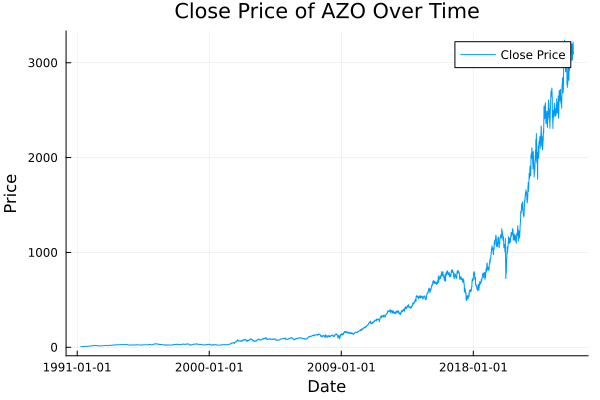

In [9]:
df = DataFrame(data) 
# Convert the index to a Date type if it's not already
df.date = Dates.Date.(df.timestamp)

# Plotting the Close prices over time
plot(df.date, df.Close, label="Close Price", xlabel="Date", ylabel="Price", title="Close Price of AZO Over Time", legend=:topright)

* We can see that the momentum picked up around 2009, with a sharp increase in price from 2018 onward (3x), except for a small dip during the COVID-19 crisis. In the next graph, we provid a zoom on the high growth period from 2018

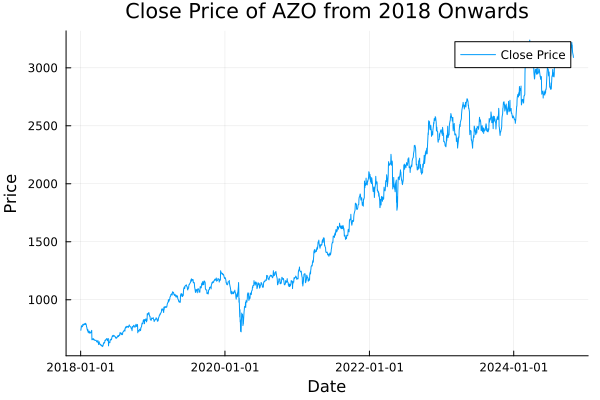

In [13]:
# Filter the DataFrame for dates from 2018 onwards
filtered_df = df[df.date .>= Date("2018-01-01"), :]

# Plotting Close prices from 2018 onwards
plot(filtered_df.date, filtered_df.Close, 
     label="Close Price", 
     xlabel="Date", 
     ylabel="Price", 
     title="Close Price of AZO from 2018 Onwards", 
     legend=:topright)

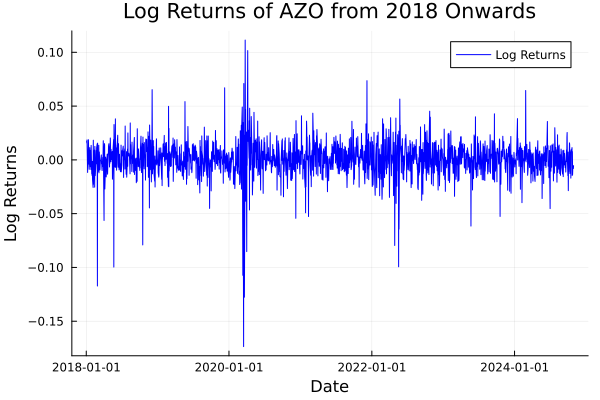

In [16]:
filtered_df.LogReturns = [NaN; log.(filtered_df.Close[2:end] ./ filtered_df.Close[1:end-1])]

plot(filtered_df.date, filtered_df.LogReturns, 
     label="Log Returns", 
     xlabel="Date", 
     ylabel="Log Returns", 
     title="Log Returns of AZO from 2018 Onwards", 
     legend=:topright, 
     color=:blue)

* We can notice some cyclicallity in returns as well as increased volatility during crises.

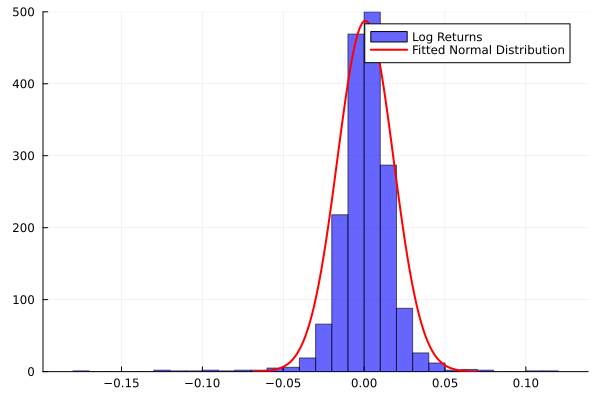

In [17]:
# Remove NaN values for histogram
log_returns = filtered_df.LogReturns[.!isnan.(filtered_df.LogReturns)]

# Calculate mean and standard deviation
mean_return = mean(log_returns)
std_return = std(log_returns)

# Create histogram of log returns
histogram(log_returns, bins=30, label="Log Returns", alpha=0.6, color=:blue, legend=:topright)

normal_dist = Normal(mean_return, std_return)

# Overlay the fitted normal distribution
x = range(mean_return - 4*std_return, stop=mean_return + 4*std_return, length=100)
y = 1.3*pdf(normal_dist, x)  # Calculate PDF of the fitted normal distribution

# Scale the normal distribution to match histogram
bin_width = (maximum(log_returns) - minimum(log_returns)) / 30  # Assuming 30 bins
y_scaled = y * (length(log_returns) * bin_width) 

# Plot normal distribution
plot!(x, y_scaled, label="Fitted Normal Distribution", color=:red, linewidth=2)

* Here we plot the histogram of log returns, while the red line represents the fitted normal distribution. The normal distribution seems to fit the data quite well (good to know for GARCH modeling later on), however as is usual with financial data, we can notice some heavy tails especially for the negative retunrs (<-0.15), these are likely to be attributed to the COVID-19 pandemic crash. 

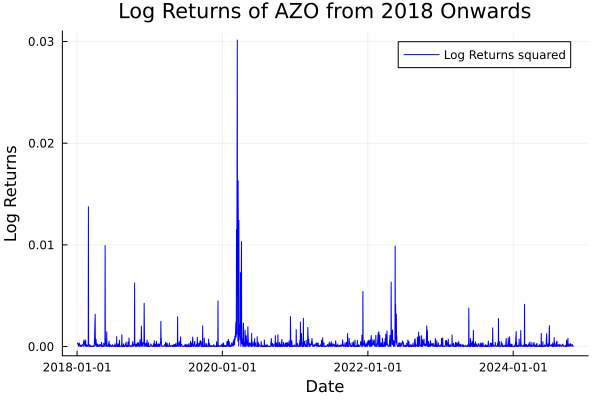

In [18]:
plot(filtered_df.date, filtered_df.LogReturns.^2, 
     label="Log Returns squared", 
     xlabel="Date", 
     ylabel="Log Returns", 
     title="Log Returns of AZO from 2018 Onwards", 1
     legend=:topright, 
     color=:blue)

In [25]:
# Summary statistics for Close prices
mean_close = mean(filtered_df.Close)
std_close = std(filtered_df.Close)
min_close = minimum(filtered_df.Close)
max_close = maximum(filtered_df.Close)

println("Summary Statistics for Close Prices:")
println("Mean: $mean_close")
println("Standard Deviation: $std_close")
println("Min: $min_close")
println("Max: $max_close")

Summary Statistics for Close Prices:
Mean: 1693.7587310826543
Standard Deviation: 776.6241862093402
Min: 595.8400268554688
Max: 3239.320068359375


In [27]:
# Summary statistics for Close prices
mean_LogReturns = mean(filtered_df.LogReturns[2:end])
std_LogReturns = std(filtered_df.LogReturns[2:end])
min_LogReturns = minimum(filtered_df.LogReturns[2:end])
max_LogReturns = maximum(filtered_df.LogReturns[2:end])

println("Summary Statistics for Close Prices:")
println("Mean: $mean_LogReturns")
println("Standard Deviation: $std_LogReturns")
println("Min: $min_LogReturns")
println("Max: $max_LogReturns")

Summary Statistics for Close Prices:
Mean: 0.0008350297190827499
Standard Deviation: 0.01734561097288014
Min: -0.17360506182752433
Max: 0.11138066306860907


In [15]:
# Get a summary of the DataFrame
summary_stats = describe(df)
println(summary_stats)

8×7 DataFrame
 Row │ variable   mean       min         median    max         nmissing  eltype   
     │ Symbol     Union…     Any         Union…    Any         Int64     DataType 
─────┼────────────────────────────────────────────────────────────────────────────
   1 │ timestamp             1991-04-02            2024-10-28         0  Date
   2 │ Open       493.119    6.875       123.7     3237.43            0  Float64
   3 │ High       498.102    7.1875      125.085   3256.37            0  Float64
   4 │ Low        488.059    6.5625      121.68    3193.76            0  Float64
   5 │ Close      493.309    7.125       123.58    3239.32            0  Float64
   6 │ AdjClose   493.309    7.125       123.58    3239.32            0  Float64
   7 │ Volume     5.30088e5  17800.0     365150.0  1.36667e7          0  Float64
   8 │ date                  1991-04-02            2024-10-28         0  Date


### ARCH modeling

#### Fitting the GARCH(1,1) model, we chose the GARCH(1,1) model because it is usually the champion model in volatility modeling

In [95]:
model = ARCHModels.fit(GARCH{1,1}, log_returns) 


GARCH{1, 1} model with Gaussian errors, T=1716.

Mean equation parameters:
──────────────────────────────────────────────
      Estimate    Std.Error  z value  Pr(>|z|)
──────────────────────────────────────────────
μ  0.000718381  0.000389284  1.84539    0.0650
──────────────────────────────────────────────

Volatility parameters:
─────────────────────────────────────────────
      Estimate   Std.Error  z value  Pr(>|z|)
─────────────────────────────────────────────
ω   2.89849e-5  1.50432e-5  1.92678    0.0540
β₁  0.803543    0.0830809   9.67182    <1e-21
α₁  0.0848417   0.0334154   2.539      0.0111
─────────────────────────────────────────────


#### We forecast using rolling window of length 200; in this case, we predict the variance of the next day's return

In [213]:
T = length(log_returns)
preds_vec = Float64[]
windowsize = 200
forecast_dates = filtered_df.date[windowsize+1:T-1]
for t = windowsize+1:T-1
    m = fit(GARCH{1, 1}, log_returns[t-windowsize:t])
    var = predict(m, :variance, 1)
    push!(preds_vec, var[1])
end

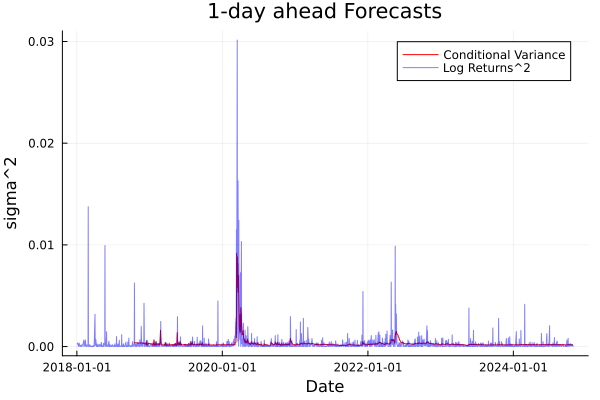

In [214]:
plot(forecast_dates, preds_vec, label="Conditional Variance", color=:red, ylabel="sigma^2", xlabel="Date", title="1-day ahead Forecasts")
plot!(filtered_df.date[2:end], log_returns.^2, label="Log Returns^2", color=:blue, alpha=0.5)

* diffcult to see the fit, hence we will comapre forecasted sigma from GARCH model with 5 days moving average of $\sqrt{{log returns^2}}$ (volatility)

In [28]:
window_size = 5


five_day_volatility = Float64[]
lr2 = log_returns.^2

for t in window_size+1:length(lr2)-1
    push!(five_day_volatility, sqrt(mean(lr2[t-window_size:t])))
end



In [29]:
T = length(log_returns)
preds_vec = Float64[]
windowsize = 200
forecast_dates = filtered_df.date[windowsize+1:T-1]
for t = windowsize+1:T-1
    m = fit(GARCH{1, 1}, log_returns[t-windowsize:t])
    var = sqrt(predict(m, :variance, 1))
    push!(preds_vec, var[1])
end

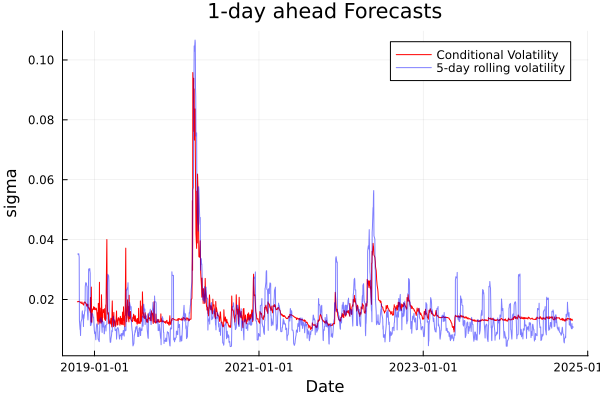

In [30]:
plot(forecast_dates, preds_vec, label="Conditional Volatility", color=:red, ylabel="sigma", xlabel="Date", title="1-day ahead Forecasts")
plot!(filtered_df.date[203:end], five_day_volatility[196:end], label="5-day rolling volatility", color=:blue, alpha=0.5)

* we see that the garch is relatively slowly adjusting, however, we can notice that from 2023 it is rather constant and not able to properly model the volatility of the stock. However, we need to take into account that we use a rather imprecise measure of volatility, if we would have more granular data at a day level and thus be able to assemble realized volaitlity we would probably see a better fit.